# IMPORTS

In [1]:
import time
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError

In [2]:
titulos = pd.read_csv('../../Datasets/Complete Dataset.csv')
titulos['data_base'] = pd.to_datetime(titulos.data_base)
titulos.set_index('data_base', inplace=True)

IPCA_2024 = titulos[titulos['titulo']=='Tesouro IPCA+ 15/08/2024']
IPCA_2024 = IPCA_2024.drop(columns=['titulo'])

# REFRAME THE DATASET TO SUPERVISED

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(df.columns.values.tolist()[j] + '(t-%d)' % (i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df['taxa_compra'].shift(-i))
        if i == 0:
            names.append('taxa_compra(t)') #[(df.columns.values.tolist()[j] + '(t)') for j in range(n_vars)]
        else:
            names.append('taxa_compra(t+%d)') %(i) #[(df.columns.values.tolist()[j] + '(t+%d)' % (i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# split into train and test sets
def split_train_test(dataset):
    values = dataset.values
    division_train = int(dataset.shape[0]*0.6)
    division_validation = int(dataset.shape[0]*0.8)
    
    train = values[:division_train]
    validation = values[division_train:division_validation]
    test = values[division_validation:]
    
    # split into input and outputs
    # output: taxa_compra(t), input: everything else
    train_input, train_output = train[:, :-1], train[:, -1]
    validation_input, validation_output = validation[:, :-1], validation[:, -1]
    test_input, test_output = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_input = train_input.reshape((train_input.shape[0], 1, train_input.shape[1]))
    validation_input = validation_input.reshape((validation_input.shape[0], 1, validation_input.shape[1]))
    test_input = test_input.reshape((test_input.shape[0], 1, test_input.shape[1]))
    
    return train_input, train_output, validation_input, validation_output, test_input, test_output

# NEURAL NETWORK STRUCTURE

In [5]:
def plot_graph(x, y, label_x, label_y, name_x, name_y, title):
    plt.plot(x, label=label_x)
    plt.plot(y, label=label_y)
    plt.xlabel(name_x,fontsize=10)
    plt.ylabel(name_y,fontsize=10)
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
def rmse(inputs, output, model):
    # make a prediction
    prediction = model.predict(inputs)
    inputs = inputs.reshape((inputs.shape[0], inputs.shape[2]))

    # invert scaling for forecast (go back to the regular rates)
    forecast = np.concatenate((prediction, inputs[:, 1:]), axis=1)
    forecast = scaler.inverse_transform(forecast)
    forecast = forecast[:,0]

    # invert scaling for actual
    output = output.reshape((len(output), 1))
    actual = np.concatenate((output, inputs[:, 1:]), axis=1)
    actual = scaler.inverse_transform(actual)
    actual = actual[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(actual, forecast))
    return rmse, forecast, actual

In [7]:
def cnn():
    # design network
    model = Sequential()
    model.add(
        Conv1D(
            filters=filters,
            kernel_size=1,
            activation = activation_function,
            input_shape = (train_input.shape[1], train_input.shape[2])
        )
    )
    
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(neurons, activation=activation_function))
    model.add(Dense(1))
    
    model.compile(
        loss = loss,
        optimizer = optimizer
    )

    # fit network
    history = model.fit(
        train_input,
        train_output,
        validation_data = (validation_input, validation_output),
        epochs = epochs,
        batch_size = batch_size,
        verbose = 0, 
        shuffle = False
    )
    
    return model, history

In [8]:
def run_network():
    #runs the network and shows the result
    model, history = cnn()
    plot_graph(history.history['loss'], history.history['val_loss'], 'train', 'test', 'Epoch', 'Loss', 'Loss during training')

    #calculate RMSE for test, train and validation
    rmse_test, forecast_test, actual_test = rmse(test_input, test_output, model)
    rmse_train, forecast_train, actual_train = rmse(train_input, train_output, model)
    rmse_validation, forecast_validation, actual_validation = rmse(validation_input, validation_output, model)

    # calculate RMSE for the actual data (difference from t to t-1)
    rmse_actual = sqrt(mean_squared_error(reframed['taxa_compra(t-1)'], reframed['taxa_compra(t)']))

    print('Test RMSE: %.3f' % rmse_test)
    print('Train RMSE: %.3f' % rmse_train)
    print('Validation RMSE: %.3f' % rmse_validation)

    #turns np array to dataframe in order to have the dates back (test)
    actual_new = pd.DataFrame(data=actual_test, index=reframed[int(reframed.shape[0]*0.8):].index)
    forecast_new = pd.DataFrame(data=forecast_test, index=reframed[int(reframed.shape[0]*0.8):].index)
    
    return model, actual_new, forecast_new

# RUNNING

In [9]:
# define a escala de normalizacao
scaler = MinMaxScaler(feature_range=(-1, 1))

# configure network
filters = 128
neurons = 1000
activation_function = 'tanh'
learning_rate = 3.111548415565516e-05

loss = 'mse'
optimizer = Adam(learning_rate=learning_rate)

epochs = 400
batch_size = 128

In [10]:
columns_drop = [
    [],
    ['cdi'],
    ['ipca'],
    ['selic'],
    ['cdi', 'ipca'],
    ['cdi', 'selic'],
    ['ipca', 'selic'],
    ['cdi', 'ipca', 'selic']
]

Droping columns: []


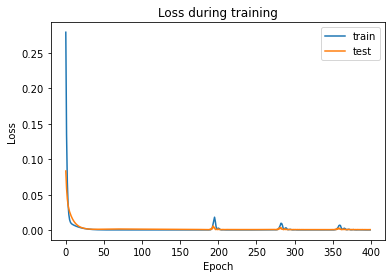

Test RMSE: 0.138
Train RMSE: 0.067
Validation RMSE: 0.105


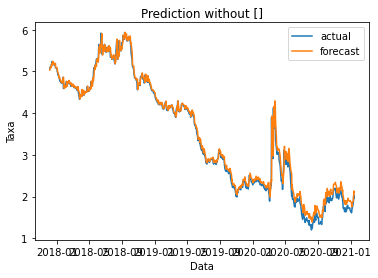

--- 86.13174176216125 seconds ---
-----------------------------------------------------
Droping columns: ['cdi']


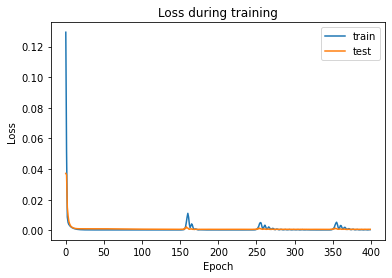

Test RMSE: 0.115
Train RMSE: 0.073
Validation RMSE: 0.100


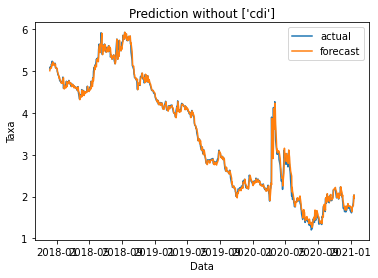

--- 79.085116147995 seconds ---
-----------------------------------------------------
Droping columns: ['ipca']


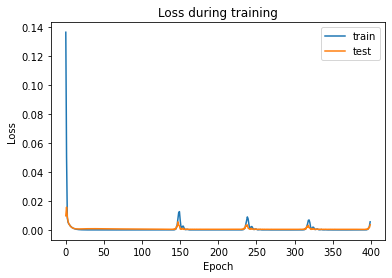

Test RMSE: 0.516
Train RMSE: 0.451
Validation RMSE: 0.240


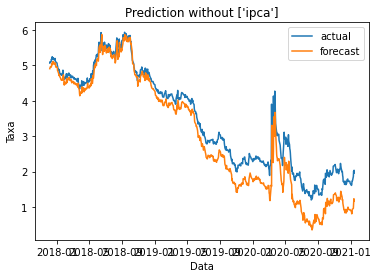

--- 77.48443794250488 seconds ---
-----------------------------------------------------
Droping columns: ['selic']


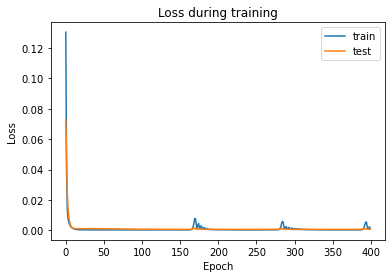

Test RMSE: 0.142
Train RMSE: 0.121
Validation RMSE: 0.102


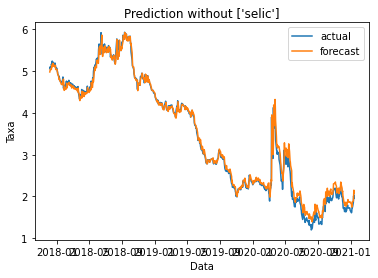

--- 83.68630623817444 seconds ---
-----------------------------------------------------
Droping columns: ['cdi', 'ipca']


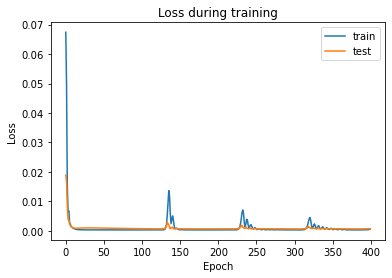

Test RMSE: 0.199
Train RMSE: 0.132
Validation RMSE: 0.099


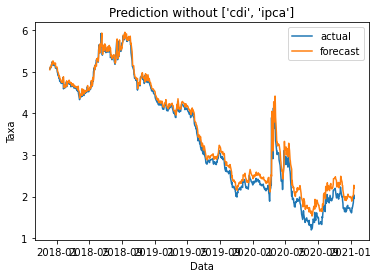

--- 89.26035714149475 seconds ---
-----------------------------------------------------
Droping columns: ['cdi', 'selic']


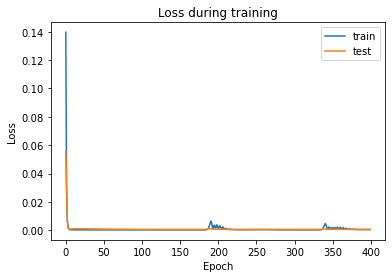

Test RMSE: 0.130
Train RMSE: 0.115
Validation RMSE: 0.100


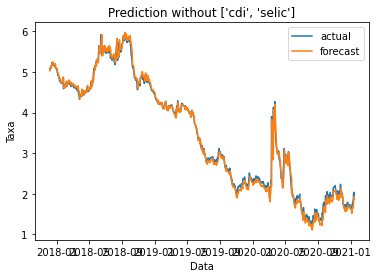

--- 83.09364104270935 seconds ---
-----------------------------------------------------
Droping columns: ['ipca', 'selic']


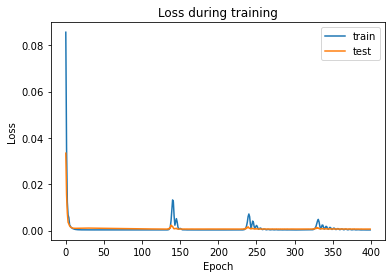

Test RMSE: 0.121
Train RMSE: 0.065
Validation RMSE: 0.099


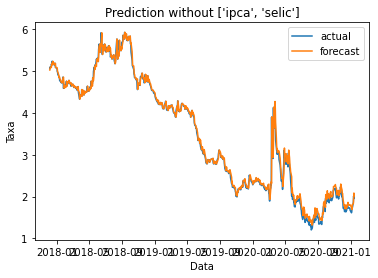

--- 85.23339462280273 seconds ---
-----------------------------------------------------
Droping columns: ['cdi', 'ipca', 'selic']


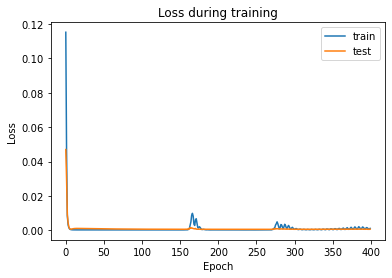

Test RMSE: 0.176
Train RMSE: 0.178
Validation RMSE: 0.105


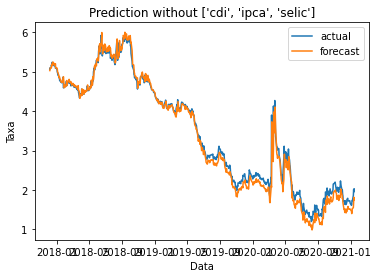

--- 80.97147917747498 seconds ---
-----------------------------------------------------


In [11]:
models = []
actuals = []
forecasts = []

for i in range(len(columns_drop)):
    start_time = time.time()
    
    print('Droping columns: ' + str(columns_drop[i]))
    dataset = IPCA_2024.drop(columns=columns_drop[i])
    
    # normaliza os valores
    dataset[dataset.columns.values.tolist()] = scaler.fit_transform(dataset)
    
    # (dataset, days_input, days_output)
    reframed = series_to_supervised(dataset, 1, 1)
    train_input, train_output, validation_input, validation_output, test_input, test_output = split_train_test(reframed)
    
    model, actual, forecast = run_network()
    models.append(model)
    actuals.append(actual)
    forecasts.append(forecast)
    
    plot_graph(actuals[i], forecasts[i], 'actual', 'forecast', 'Data', 'Taxa', 'Prediction without %s' % columns_drop[i])
    print("--- %s seconds ---" % (time.time() - start_time))
    print('-----------------------------------------------------')

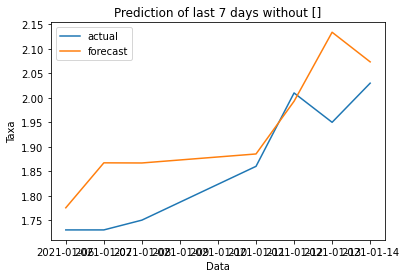

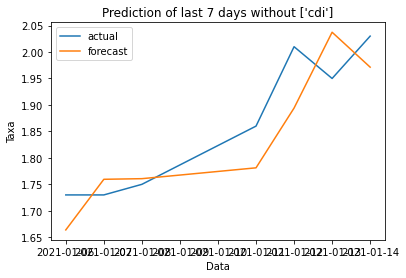

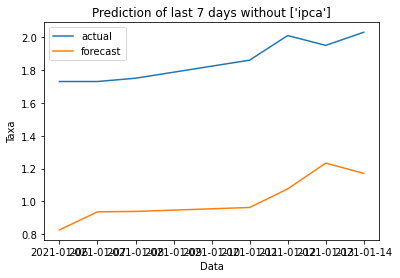

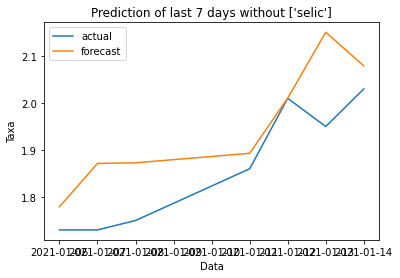

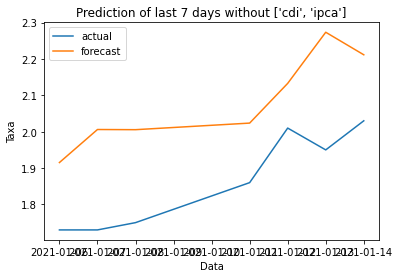

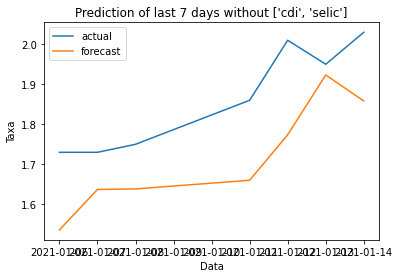

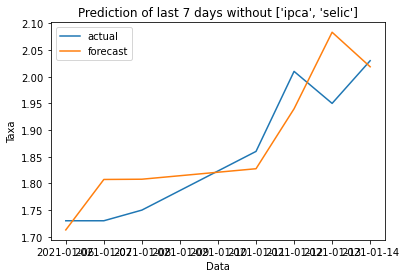

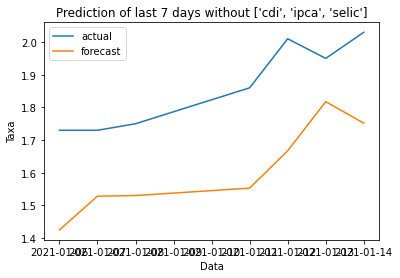

In [12]:
for i in range(len(columns_drop)):
    plot_graph(actuals[i][-7:], forecasts[i][-7:], 'actual', 'forecast', 'Data', 'Taxa', 'Prediction of last 7 days without %s' % columns_drop[i])

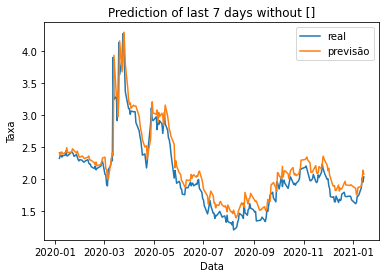

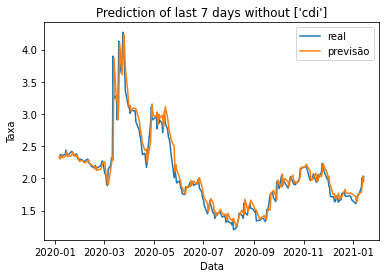

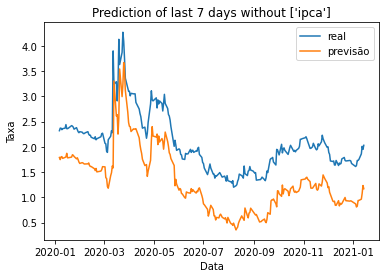

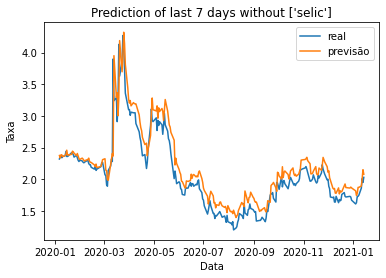

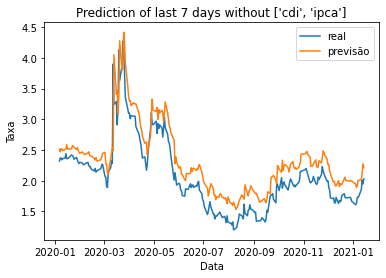

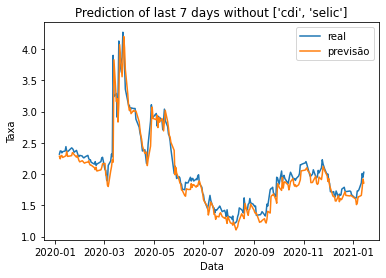

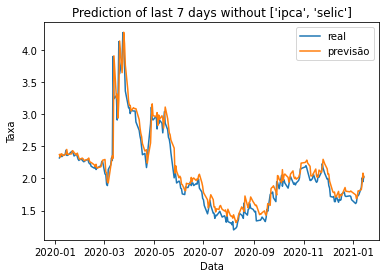

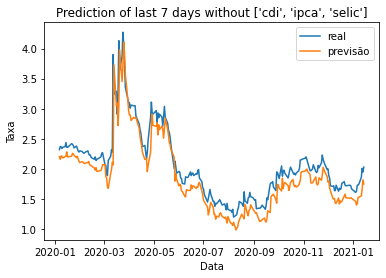

In [13]:
for i in range(len(columns_drop)):
    plot_graph(actuals[i][-250:], forecasts[i][-250:], 'real', 'previsão', 'Data', 'Taxa', 'Prediction of last 7 days without %s' % columns_drop[i])